In [1]:
import yaml
import torch
import model.cStylegan2 as sg
import model.conditionalSockets as cs
import numpy as np


/scratch/mrmn/brochetc/.conda/my_envs/metrics_num/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reading VQparams from yaml config
with open('configs/normal_exp_steps_256.yaml') as f:
    optyaml = yaml.safe_load(f)
VQparams = optyaml["VQparams"]


In [3]:
print(VQparams)

{'ddconfig': {'double_z': False, 'z_channels': 3, 'resolution': 128, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [], 'dropout': 0.0}, 'lossconfig': {'target': 'model.losses.vqperceptual.VQLPIPSWithDiscriminator', 'params': {'disc_conditional': False, 'disc_in_channels': 3, 'disc_start': 500000, 'disc_weight': 0.6, 'codebook_weight': 1.0}}, 'n_embed': 8192, 'embed_dim': 3, 'ckpt_path': '/scratch/mrmn/brochetc/GAN_2D/VQ-GAN/EnDecoder_vqgan/checkpoints/gens_vqgan_fl4_D3_N8192_32x32x3_cyclic_3717.ckpt'}


In [4]:
vqs = cs.vqSocket(VQparams, discrete_level=1)

making attention of type 'vanilla' with 512 in_channels


Working with z of shape (1, 3, 32, 32) = 3072 dimensions.


making attention of type 'vanilla' with 512 in_channels
Restored from /scratch/mrmn/brochetc/GAN_2D/VQ-GAN/EnDecoder_vqgan/checkpoints/gens_vqgan_fl4_D3_N8192_32x32x3_cyclic_3717.ckpt with 0 missing and 55 unexpected keys


In [5]:
for i,p in enumerate(vqs.VQ.encoder.conv_in.parameters()):
    print(p.shape)

torch.Size([128, 3, 3, 3])
torch.Size([128])


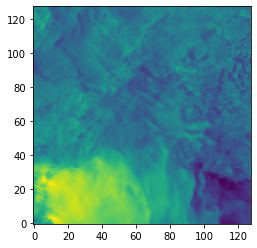

In [6]:
X = np.load('/scratch/mrmn/brochetc/GAN_2D/datasets_full_indexing/IS_1_1.0_0_0_0_0_0_256_done/_sample0.npy')[1:4,78:206,55:183]
mean = np.load('/scratch/mrmn/brochetc/GAN_2D/datasets_full_indexing/IS_1_1.0_0_0_0_0_0_256_done/mean_with_orog.npy')[1:4].reshape(3,1,1)
maxs = np.load('/scratch/mrmn/brochetc/GAN_2D/datasets_full_indexing/IS_1_1.0_0_0_0_0_0_256_done/max_with_orog.npy')[1:4].reshape(3,1,1)

X = 0.95 * (X-mean)/maxs

import matplotlib.pyplot as plt

plt.imshow(X[0], origin='lower', cmap='viridis')

In [7]:
XX = torch.tensor(X[np.newaxis,:,:,:], dtype=torch.float32)
with torch.no_grad():
    y, diff = vqs.VQ(XX)


torch.Size([1, 3, 128, 128])


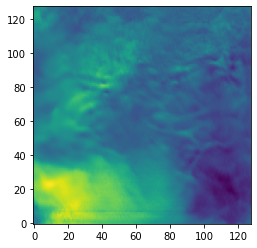

In [8]:
print(y.shape)
plt.imshow(y[0,0].detach().numpy(), origin='lower', cmap='viridis')

In [9]:
with torch.no_grad():
    yy = vqs(XX)

In [10]:
print(yy.shape)

torch.Size([1, 6, 32, 32])


In [11]:
ls = cs.LinearSocket(3,128,128,512)

In [12]:
yd = torch.flatten(XX, start_dim=1)
yd.requires_grad_()
print(yd.shape, 3 * 128 * 128)
cout = torch.empty((1,49152)).normal_().requires_grad_()
l = torch.sum(cout * yd, dim=1, keepdims=True)
print(l, l.shape)

torch.Size([1, 49152]) 49152
tensor([[-11.3973]], grad_fn=<SumBackward1>) torch.Size([1, 1])
